## Dataset & Dataloader
데이터 샘플을 처리하는 코드는 지저분하고 유지보수가 어려울 수 있다.
readability & modularity를 위해 데이터셋 코드를 모델 학습 코드로부터 분리하는 것이 좋다.
pytorch에서는 torch.utils.data.DataLoader와 torch.utils.data.Dataset의 두가지 데이터 기본 요소를 제공하여 데이터 불러오기, 데이터 사용, 등 다양한 기능을 제공한다.
- Datset은 샘플과 정답을 저장한다.
- DataLoader는 Datset을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감싼다.

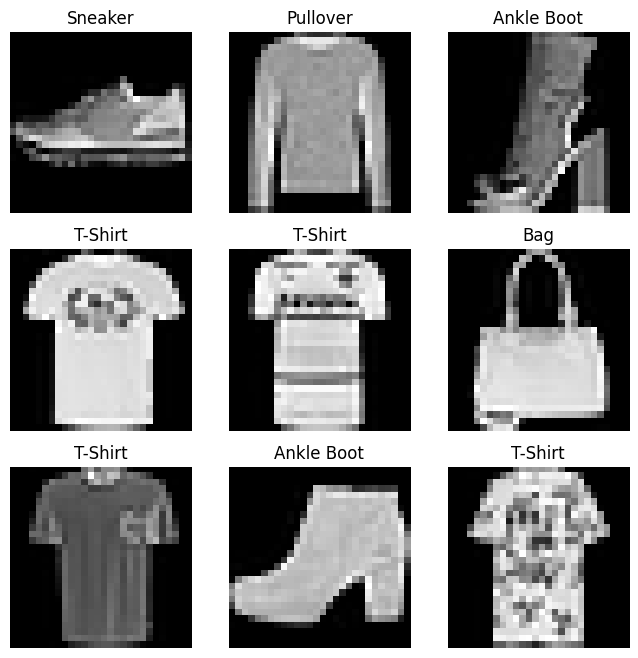

In [2]:
# 데이터셋 불러오기
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8,8))
cols,rows = 3,3
for i in range(1,cols*rows+1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 파일에서 사용자 정의 데이터셋 만들기
사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야한다. : ___init__,__len__,and __getitem__
아래 구현을 보면, FashionMNIST 이미지들은 img_dir 디렉토리에 저장되고, label은 annotations_file csv 파일에 별도로 저장된다.
- __init__ 함수는 Dataset 객체가 생성될 때 한번만 실행된다. 여기서는 이미지와 주석파일이 포함된 디렉토리와 두가지 transform을 초기화한다.
- __len__ 함수는 데이터셋의 샘플 개수를 반환한다.
- __getitem__ 함수는 주어진 인덱스에 해당하는 샘플을 데이터셋에서 불러오고 반환한다. 인덱스를 기반으로, 디스크에서 이미지의 위치를 식별하고, read_image를 사용하여 이미지를 텐서로 변환하고, self.img_labels의 csv 데이터로부터 해당하는 정답을 가져오고, transform 함수들을 호출한뒤, 텐서 이미지와 라벨을 python dictionary 형으로 반환한다.

In [3]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels=pd.read_csv(annotations_file, names=['file_name','label'])
        self.img_dir =  img_dir
        self.transform=transform
        self.target_transform=target_transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## DataLoader로 학습용 데이터 준비하기
Dataset은 데이터셋의 특징을 가져오고 하나의 샘플에 label을 지정하는 일을 한번에 처리한다. 모델을 학습할 때, 일반적으로 샘플들을 미니배치로 전달하고, 매 epoch마다 데이터를 다시 섞어서 overfit을 막고, python의 multiprocessing을 사용하여 데이터 검색 속도를 높이려한다.

DataLoader는 간단한 API로 이러한 복잡한 과정들을 추상화한 iterable 객체이다.

In [4]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=64, shuffle=True)

d